# PyMC3

Notes on uses of PyMC3

- [Github pymc3](https://github.com/pymc-devs/pymc3)
- [Distributions](http://pymc-devs.github.io/pymc3/manual/api.html#distributions)

In [2]:
%matplotlib inline

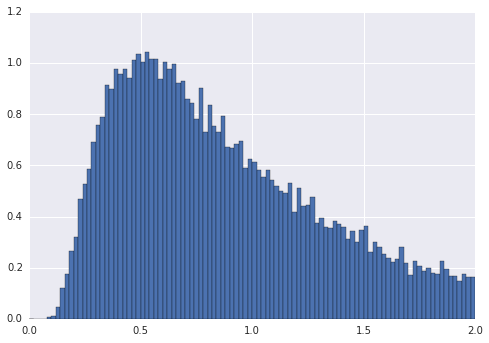

In [57]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import numpy.random

def monte_carlo_disk(n, dt, L=1.0):
    xs = numpy.zeros((n, 2))
    D  = 1.0
    ts = []
    time = 0.0
    while xs.shape[0] > 0:
        time += dt
        sigma = numpy.sqrt(2 * D * dt)
        dx = sigma * numpy.random.normal(0.0, 1.0, size= xs.shape)
        xs += dx
        Ls = numpy.sqrt(numpy.sum(xs**2, axis = 1))
        absorbed = numpy.where(Ls >= L)[0]
        retain   = numpy.where(Ls < L)[0]
        if absorbed.shape[0] != 0:
            xs = xs[retain,:]
            ts.append([time]*absorbed.shape[0])
    return numpy.hstack(ts)

times = monte_carlo_disk(20000, 0.001, L=2.0)
plt.hist(times, bins = numpy.linspace(0.0, 2.0, 101), normed=True);

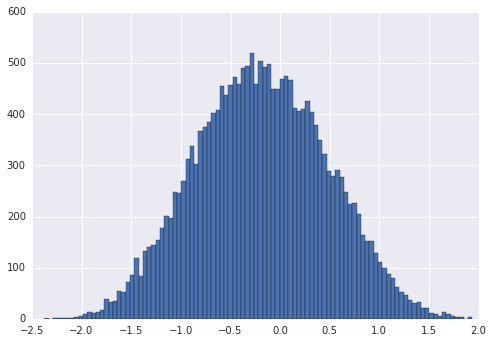

In [17]:
plt.hist(np.log(times), bins = 100);

In [32]:
from pymc3 import Model, Lognormal, Normal, HalfNormal

basic_model = Model()

with basic_model:
    alpha = Normal('alpha', mu=10, sd=2)
    beta  = HalfNormal('beta', sd=2)
    Y_obs = Lognormal('Y_obs', mu=alpha, tau=beta, observed=times+10)

Applied log-transform to beta and added transformed beta_log to model.


In [33]:
Y_obs

Y_obs

In [37]:
from pymc3 import find_MAP, NUTS, sample, traceplot

map_est = find_MAP(model=basic_model)
map_est

{'alpha': array(2.3986585903557858), 'beta_log': array(4.908739647203686)}

In [36]:
with basic_model:
    trace = sample(2000, start=map_est)

Assigned NUTS to alpha
Assigned NUTS to beta_log
 [-----------------100%-----------------] 2000 of 2000 complete in 38.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11096c090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110c23950>]], dtype=object)

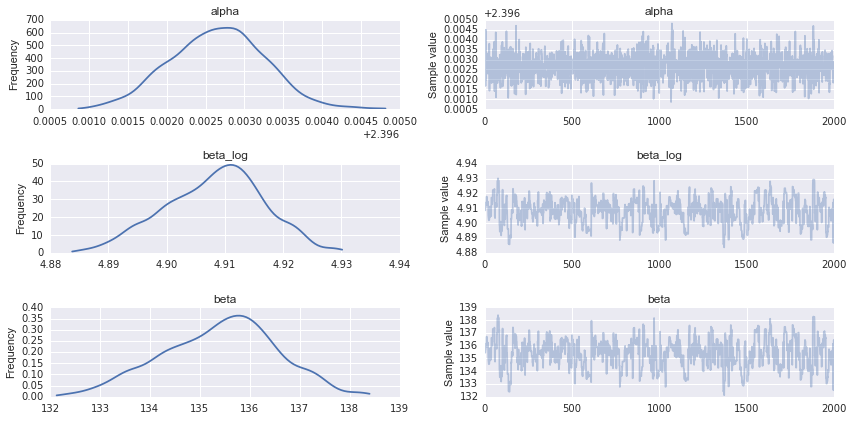

In [38]:
traceplot(trace)

In [41]:
import pandas as pd
import numpy as np
import pymc3 as pm

def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    '''

    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = seaborn.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = seaborn.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [42]:
#plot_posterior_cr(basic_model, trace, times, [0,4])
pymc3.tracep

KeyError: 'k1'

In [49]:
print basic_model.cont_vars
df = pymc3.trace_to_dataframe(trace)


[alpha, beta_log]


In [54]:
x = pymc3.Lognormal(0.0, 1.0)

TypeError: No model on context stack, which is needed to use the Normal('x', 0,1) syntax. Add a 'with model:' block